In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## STEP 2. 데이터셋 구성하기

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_X, _), (test_x, _) = cifar10.load_data()

train_X.shape

(50000, 32, 32, 3)

* 5만장의 사진을 갖고 있고, 32x32 픽셀로 이루어진 RGB 이미지
* 딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요한데, 이미 채널에 대한 정보를 포함하고 있으므로 shape 수정할 필요 없음

In [4]:
print('train_X의 max pixel:', train_X.max())
print('train_X의 min pixel:', train_X.min())

train_X의 max pixel: 255
train_X의 min pixel: 0


* 각 픽셀을 -1,1로 정규화하기

In [5]:
train_x = (train_X - 127.5) / 127.5
print('train_x의 max pixel:', train_x.max())
print('train_x의 min pixel:', train_x.min())

train_x의 max pixel: 1.0
train_x의 min pixel: -1.0


In [6]:
train_x.shape

(50000, 32, 32, 3)

* 데이터 이미지로 확인해보기

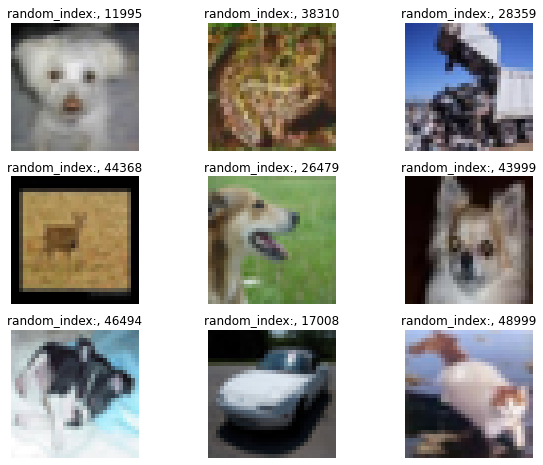

In [7]:
plt.figure(figsize=(10,8))

for i in range(9):
    plt.subplot(3, 3, i+1)
    rand_index = np.random.randint(1, 50000)
    plt.imshow(train_X[rand_index].reshape(32, 32, 3))
    plt.title(f'random_index:, {rand_index}')
    plt.axis('off')
plt.show()

* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 3. 생성자 모델 구현하기

In [8]:
def generator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First. Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second, Reshape layer
    model.add(layers.Reshape((8,8,256)))
    
    # Third. Cnv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 4th. Cnv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 5th. Cnv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2), 
                                     padding='same', use_bias=False,
                                    activation='tanh'))
    
    return model

* Conv2DTranspose layer를 세 번 지나가면서 (8,8,256) -> (16,16,64), -> (32,32,1) 순으로 이미지 키워나감. 최종 shape = train_x.shape
* BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줌
* 중간층들의 활성화 함수로 LeakyReLU사용
* 마지막 층은 'tanh'

In [9]:
generator = generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

* 노이즈 벡터 만들어서 생성자모델에 넣어서 랜덤 이미지 생성해보기

In [10]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [1]:
plt.imshow(generated_image[0,:,:, 0])
plt.colorbar()
plt.show()

NameError: name 'plt' is not defined

* 노이즈 랜덤 이미지의 shape은 (1,32,32,3)으로 생성자 출력 규격과 잘 맞음

## STEP 4. 판별자 모델 구현하기

In [12]:
def discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # 1st. Conv2D Layer
    model.add(layers.Conv2D(64,(5,5), strides=(2,2), padding='same',
                           input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 2nd. Conv2D Layer
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 3rd. Flatten Layer
    model.add(layers.Flatten())
    
    # 4th. Dense Layer
    model.add(layers.Dense(1))
    
    return model

* Conv2D 층을 거치며 (32, 32, 3) -> (16, 16, 64) -> (8, 8, 128) 로 줄어듦
* Flatten 층을 거치면서 3차원ㅇ 이미지를 1차원으로 펼쳐 8x8x128=8192 형상의 벡터로 변환
* 1차원 벡터로 변환한 이후, 마지막 Dense layer를 거쳐 하나의 값을 출력함

In [13]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

* 앞서 생성한 노이즈(가짜) 이미지를 판별자에 입력시킨 후 결과 봐보기

In [14]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00068986]], dtype=float32)>

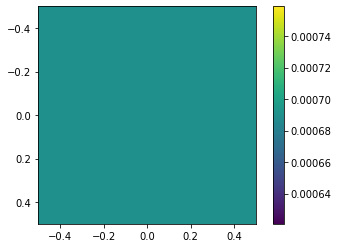

In [15]:
plt.imshow(decision)
plt.colorbar()
plt.show()

* 왜 마지막 출력으로 1을 뽑는거지?

## STEP 5. 손실함수와 최적화함수 구현하기

### 손실함수
---

* 판별자 모델의 마지막 층에는 값을 정규화 시키는 sigmoid나 tanh 함수같은 활성화 함수가 없으므로 모든 실숫값을 가질 수 있음
* binary cross entropy손실함수는 인풋값이 0-1 사이에 분포하는 확률값이라 가정하므로, 'from_logits=True'를 설정해 함수 내부세엇 sigmoid 함수를 사용해 0-1 사이의 값으로 정규화하도록 함
    * __애초에 마지막 층에 activation function 넣어주면 되는거 아닌가?__
    * __tanh를 넣으면 어떻게 될까?__

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

__생성자(generator)의 손실함수__
* 생성자는 fake_output이 1(Real image에 대한 라벨)에 가까워지는게 목적
* 모두 1로 채워진 벡터와 비교하면 됨

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

__판별자(discriminator)의 손실함수__
* 판별자는 real_output은 1에, fake_output=0에 가까워지게 분류하는게 목적
* real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

__판별자(discriminator)의 정확도__
* real_output과 fake_output의 acc가 1에 가까운 경우, 생성자가 만들어내는 fake_output이 real_output과 차이가 많이 난다는 뜻.
* 판별자가 아주 쉽게 판별해내고 있다는 뜻
* 초반에 1.0에 가깝게 나오다가, 서서히 낮아져 둘 다 0.5에 가까워지는게 이상적

In [19]:
def discriminator_accuracy(real_output, fake_output):
    # 벡터의 각 원소가 0.5 이상이면 True, True라면 1.0으로 반환
    # 이후, 결과를 평균내어 배치의 정확도 계산
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output,
                                                                tf.constant([0.5])),
                                          tf.float32))
    # 벡터의 각 원소가 0.5 이하면 True, True라면 1.0으로 반환
    # 이후 결과를 평균내어 배치의 정확도 계산
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output,
                                                       tf.constant([0.5])),
                                          tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수
---
* 생성자와 판별자는 따로 학습을 진행하는 개별 네트워크임
* 떄문에 따로 optimizer를 만들어야 함

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 생성자가 생성하는 이미지 확인
---
* 학습 진행 상황 확인을 위해 생성자가 생성한 fake_image 확인하기 위함
* num_ex_generated = 16개의 샘플 fake_image를 확인하겠다.
* 매번 같은 노이즈 샘플을 확인해야 진전과정을 확인할 수 있으므로, __고정된 seed noise__ 만들어야 함.
* 100차원의 노이즈를 갖는 16개 이미지를 계속 확인하겠다. (16, 100)

In [21]:
num_ex_generated = 16
noise_dim = 100

seed = tf.random.normal([num_ex_generated, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기

__1개의 미니배치 훈련 과정을 처리하는 'train_step()'함수 구현__

In [22]:
@tf.function
def train_step(images): # Real_image 역할을 할 Images 한 세트를 입력 받음
    # 생성자가 fake_image를 생성하기 위한 noise images 생성
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        # 생성자가 noise를 입력받은 후 generated_images 생성
        generated_images = generator(noise, training=True)
        
        # 판별자가 images(실사)와 generated_images를 각각 입력받은 후,
        # real_output, fake_output 출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # real_output과 fake_output으로 생성자와 판별자 각각의 loss 계산
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)
        
        # real_output과 fake_output으로 판별자의 accuracy계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
        # Gradient 계산. gen_tape과 dis_tape을 활용해 gradient 자동계산
        grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        grad_discriminator = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
        
        # 모델 학습. 계산된 gradient를 optimizer에 입력해 가중치 갱신
        generator_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))
        
        return gen_loss, dis_loss, real_accuracy, fake_accuracy

__위 train_step이 끝날때 학습 현황을 볼 수 있도록 샘플 생성 함수 만들기__

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    
    fig=plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]): # 16
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
               .format(os.getenv('HOME'), epoch, it))
    plt.show()

__훈련 epoch마다 loss, accuray 히스토리를 시각화하는 함수 구현__

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    # loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['dis_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'dis_loss'], loc='upper left')
    
    # accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # epoch별 그래프 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()   

__정기적으로 모델 저장하기 위한 checkpoint 생성__
* 생성자와 판별자가 학습한 모델의 가중치 저장

In [25]:
checkpoint_dir = './cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                             discriminator_optimizer = discriminator_optimizer,
                             generator = generator,
                             discriminator = discriminator)

## STEP 7. 학습 과정 진행하기

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss' : [], 'dis_loss' : [], 'real_accuracy' : [], 'fake_accuracy' : []}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, dis_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['dis_loss'].append(dis_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 ==0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)                

In [27]:
save_every = 5
EPOCHS = 50

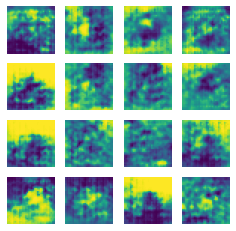

Time for training : 801 sec


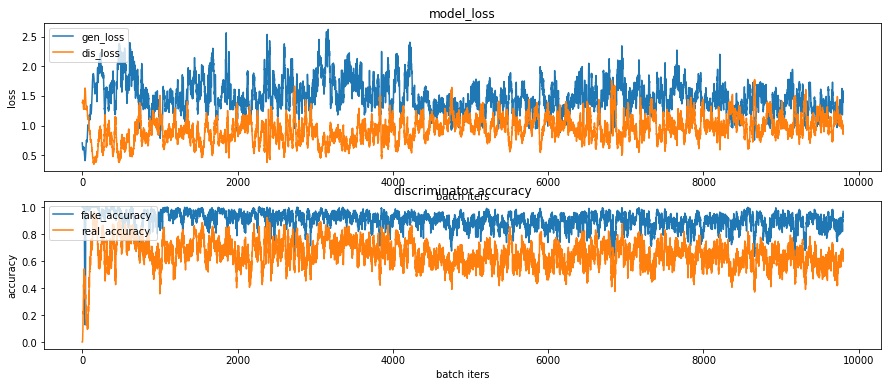

CPU times: user 13min 38s, sys: 1min 22s, total: 15min
Wall time: 13min 22s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

### 학습과정 시각화하기

In [35]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1007182 Apr 25 03:38 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


### 개선 시도 1 [모델수정](https://github.com/LubyJ/LubyJ/blob/master/EP11_test1_%EB%AA%A8%EB%8D%B8%EC%88%98%EC%A0%95.ipynb)
* 생성자 모델 수정
    1. 4부터 시작해서 4 -> 8 -> 16-> 32 순으로 커지도록 수정 (Conv2DT layer 한 개 추가)
    2. LeakyReLU에 alpha값 0.2로 지정
    3. use_bias 모두 True로 변경
    
* 판별자 모델 수정
    1. 32부터 시작해서 32 -> 16 -> 8-> 4 순으로 작아지도록 수정 (Conv2DT layer 한 개 추가)
    2. LeakyReLU에 alpha값 0.2로 지정
    3. 각 Layer마다 있던 Dropout 없애고 마지막 층에만 둠 (Dropout(0.4))
* 200 epoch
    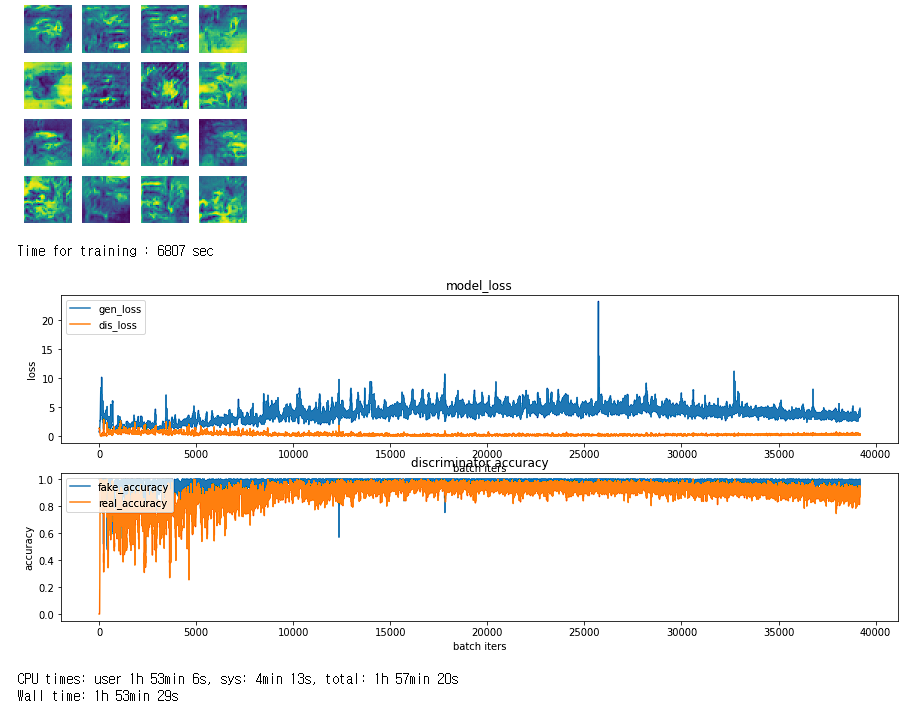
    
* 판별자 모델에 Dropout 다시 추가(200 epoch)
    * 앞부분에서 generator의 loss가 증가했다가 감소하는 양상을 보임. generator가 생성한 이미지가 discriminator 모델을 지났을 때 나온 값이 1에서 멀어졌다는 의미로, real image와 매우 다른 형태를 보이는 것을 뜻함. 이때의 fake accuracy도 1에 근접함.
    * 이후에 gen loss가 다시 감소되면서 fake accuracy가 조금씩 떨어지고, 이미지의 형태가 점점 잡히고 있으나 여전히 불완전함
    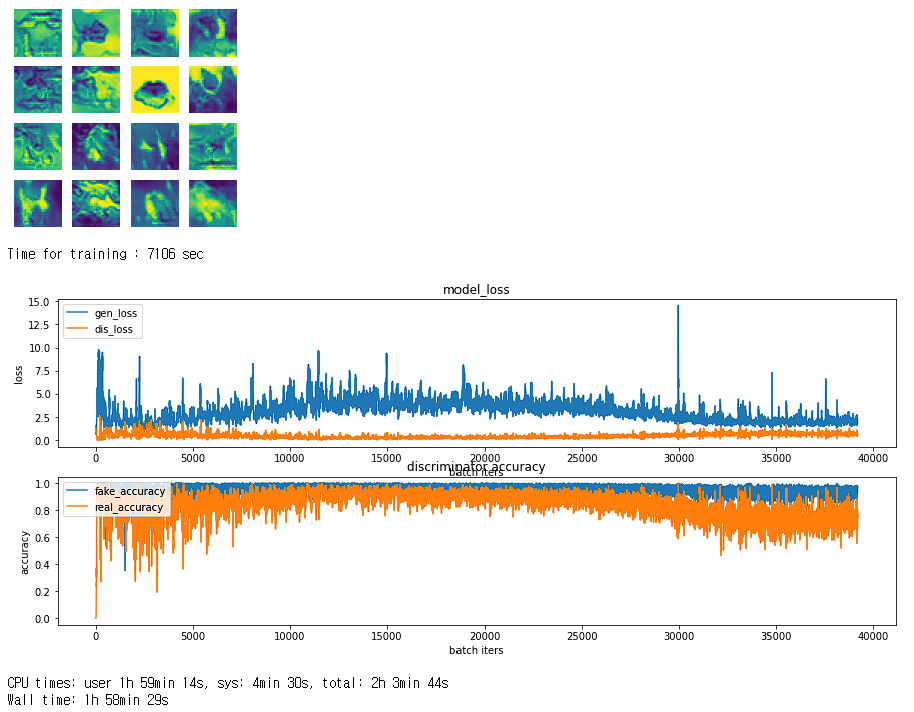
* epoch 수를 늘려봄(500 epoch)
    * real accuracy와 fake accuracy가 점차 감소하는 양상을 보임 
    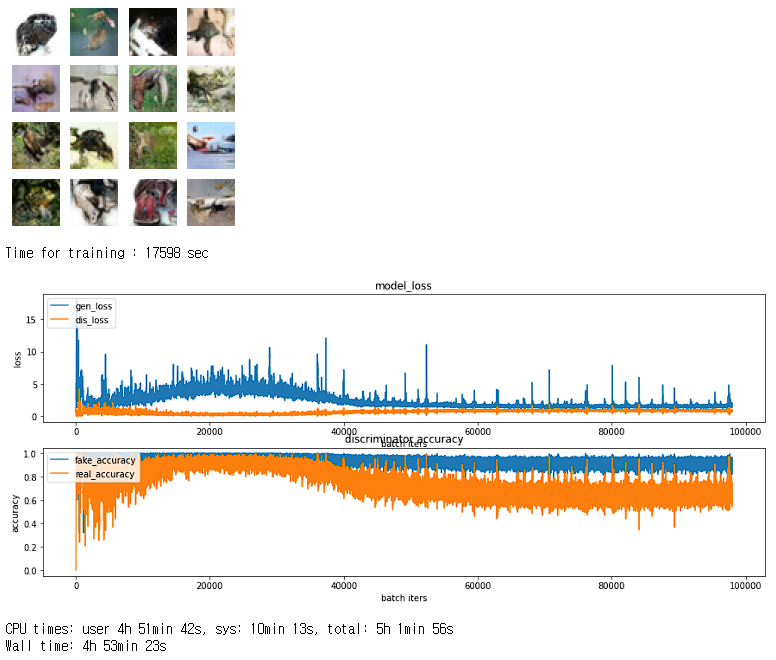
    
* checkpoint 이용해서 500 에포크 후에 700 에포크 추가적으로 돌려봄
    * 얼추 형체가 보이지만, 뚜렷하지는 않음.
    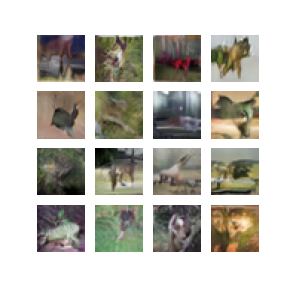
    * Real accuracy와 Fake accuracy가 더 감소하기를 바랐지만, real accuracy는 다시 상승하고 fake accuracy는 감소할 기미가 안보임(생성자가 만든 사진으로 판별자를 속이고 있지 못하다는 뜻)
    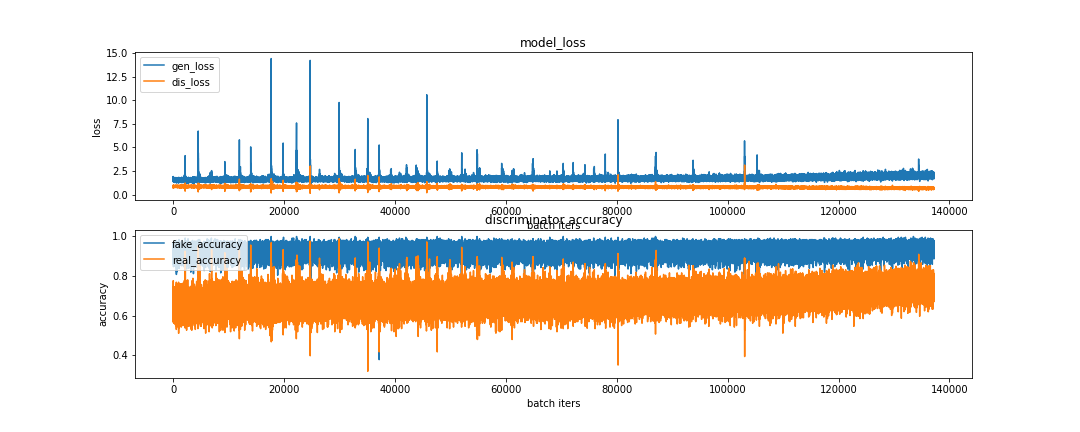

### 개선 시도 2 [손실함수 수정](https://github.com/LubyJ/LubyJ/blob/master/EP11_test2_%EC%86%90%EC%8B%A4%ED%95%A8%EC%88%98%EC%88%98%EC%A0%95.ipynb)
* 정진님이 다양한 종류의 GAN이 있는데, 각 GAN의 차이는 손실함수 차이라서, 모델을 수정하는 것보다 손실함수를 수정해보는게 좋을 것 같다고 하셨다. 찾아보니 아래와 같이 loss function 종류에 따라 다양한 GAN 모델이 존재했고, 이 중 코드 구현이 가장 간단해 보이던... WGAN을 사용해봤다.
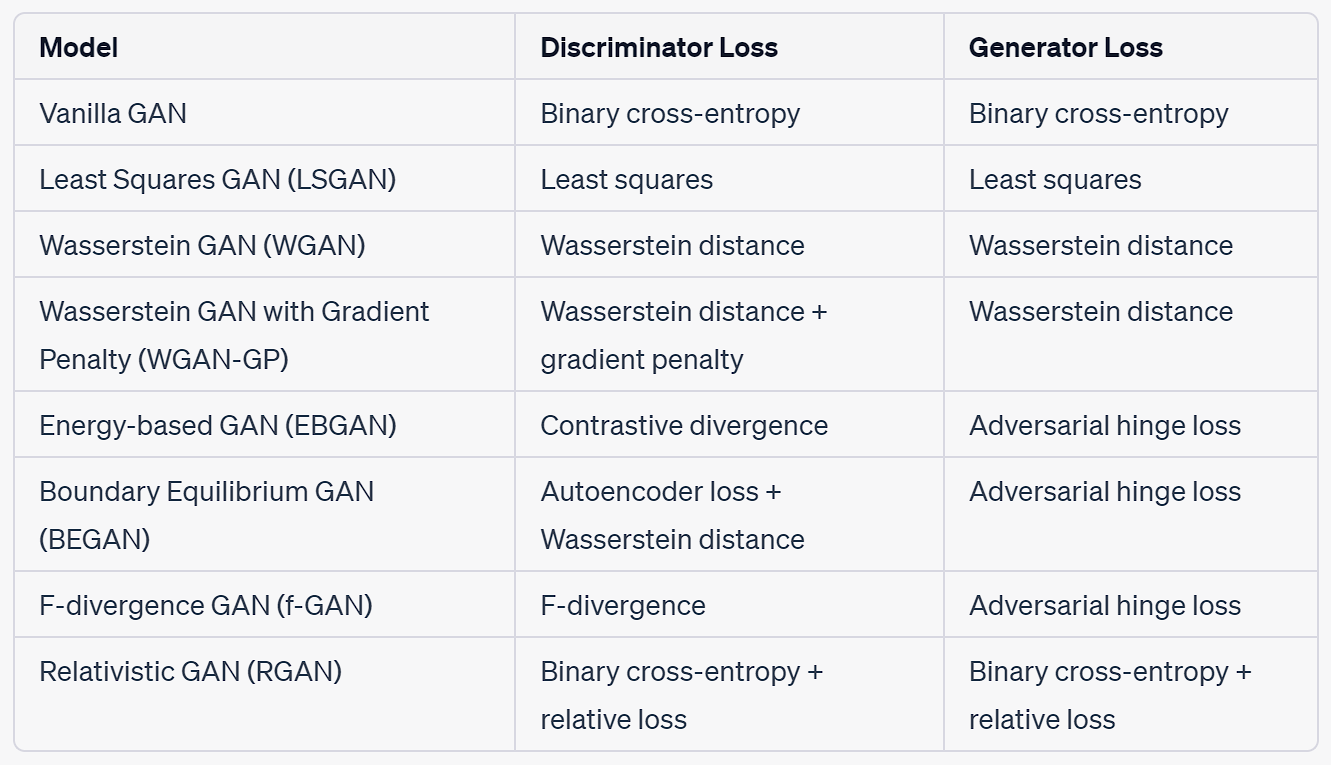
* WGAN 사용 시 generator loss는 fake_output tensor의 평균에 -부호를 취한 값을, 판별자 loss는 (fake_output tensor 평균) - (real_ouput tensor의 평균)으로 계산된 값을 사용한다. Wasserstein 관련 글을 몇 개 읽어봤는데 저 loss를 썼을 때의 이점과 저러한 loss가 어떻게 GAN 모델의 성능을 향상시킬 수 있는지 뚜렷하게 알지는 못했다.
* 시간관계상 한 번(700 epoch) 밖에 못돌려봤지만, DCGAN보다 성능이 좋지는 않았다. 모델에 대한 이해가 없어서 어디가 문제인지 모르겠다.
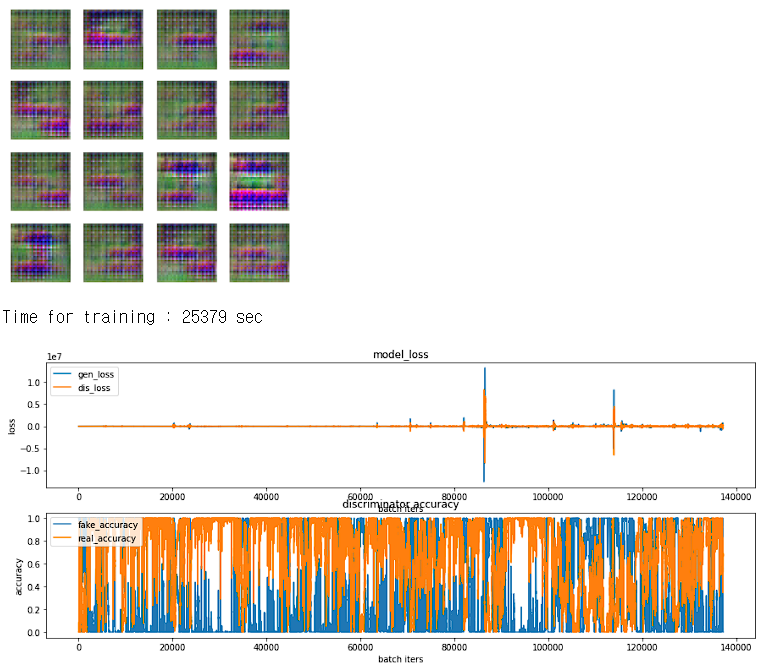

### Refs
---
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/